# Data Mining and Search Tools
### Working with Record and Catalog wrappers for Python dataframes
Created by Neil Aitken, UBC Digital Scholarship in the Arts

In this scenario, we have been given access to the data dump of an online course reserve database in the form of either an Excel spreadsheet (xlsx) or comma-separated values (csv) file. This file is then read into a dataframe structure using pandas library.

This notebook shows how to define and use the Record and Catalog objects to wrap the dataframe so that we can access the data and produce reports in a more intuitive way.


### Import code libraries for file access, csv, and data parsing and analysis

In [2]:
import os
import pandas as pd

Define the external datafile (csv or xlsx)

In [3]:
DATA_FILE = 'course_reserve_dataset.csv'

### Upload a data file containing LOCR info (CSV or Excel format)

In [4]:
from google.colab import files
uploaded = files.upload()

Saving course_reserve_dataset.csv to course_reserve_dataset.csv


### Define load functions: *load_csv()* and *load_excel()*

In [5]:
# Load csv file and returns dataframe
def load_csv(fname):
   import pandas as pd
   return pd.read_csv(fname)

# Load excel file and returns dataframe
def load_excel(fname):
  import pandas as pd
  return pd.read_excel(fname)

# Load file and determine if Excel or csv, then return dataframe
def load_datafile(fname):
  start = len(fname)-5
  if start < 0:
    start = 0
  num_periods = fname.count('.',start,len(fname))
  if num_periods == 1:
    name,extension = fname.split('.')
    if extension == 'xlsx' or extension == 'xls':
      print('Excel sheet')
      return load_excel(fname)
    else:
      print('CSV doc')
      return load_csv(fname)
  elif num_periods == 0:
    print('Filename should have a .csv, .txt, or .xlsx extension')
  else:
    print('Filename is improperly formatted. Please rename and ensure it is a CSV or Excel file')
  return None



In [6]:
# ==============================================================
# RECORD - an object wrapper for each record in the dataset
# ==============================================================

class Record:
    # Setup Record from row from a dataframe
    def __init__(self,keys,datalist):
        i = 0
        self.keys = keys

        for val in datalist:
            setattr(self,str(keys[i]),val)
            i+=1

        # Each entry in the course reserves data has a course code and course number stored separately.
        # We combine them to form the course ID and store it in the record as a new field to save time
        try:
          self.course_id = str(getattr(self,'Course code'))+' '+str(self.Coursenumber)
        except:
          print(f'Keys = {keys}')

    # Set/reset the record using the column names and row data from a row
    def read(self,headers,series):
      for hd in headers:
        setattr(self,hd,series[hd])

    # Return the value for a given key/field, or return everything if given "all"
    def get(self,rkey='all'):
        if rkey == 'all' or not rkey in vars(self):
            result =''
            for key in vars(self):
                result = result +'\n' + getattr(self,key)
            return result
        else:
            return getattr(self,rkey)

    # Check to see if the record contains a given value or partial search string
    def has_str(self,searchstr):
        import re
        for key in vars(self):
            strmatch = re.search(searchstr,self.get(key))
            if not strmatch==None:
                return True
        return False

    # Return the contents of the record as a printable string, either in brief format, just the keys, or containing everything
    def dump(self,rkey='all'):
        if rkey=='brief':
            result = '"'+str(self.Title)+'," '+str(self.Author)+', '+str(getattr(self,'Call number'))+' '+str(self.course_id)
        elif rkey == 'all' or not rkey in vars(self):
            for key in vars(self):
                if not key == 'keys':
                    result = key+': '+str(getattr(self,key))
        elif rkey=='keys':
            result = self.keys
        else:
          result = rkey+': '+str(getattr(self,rkey))
        return result

    # Print the contents of the record to the terminal
    def print(self,rkey='all'):
      print(self.dump(rkey))


# ==============================================================
# CATALOG - An object wrapper for managing a set of Records
# ==============================================================
class Catalog:
    # Setup Catalog by reading in a dataframe and all its contents as Records
    def __init__(self,df):
        self.dataframe = df
        self.catalog = []
        self.keys = df.columns
        for ind in range(0,len(df)):
             record = Record(self.keys,list(df.loc[ind]))
             self.catalog.append(record)

    # Print the catalog's records by dumping the contents of each record
    def print(self,key='all'):
        for ind in range(0,len(self.catalog)):
            print(self.catalog[ind].print(key))

    # Return the catalog
    def get(self):
        return self.catalog

    # Sort catalog based on field (ascending/descending)
    def sort(self,field,descending=True):
        self.catalog.sort(key=lambda x: str(getattr(x,field)),reverse=descending)

    # Search the catalog for all records containing a match or partial match of the value for a given key
    def search(self,key,value):
        import re
        results = []
        if value == '*':
          return self.catalog

        for record in self.catalog:
            if key in vars(record):
                occ = re.search(value.lower(),str(getattr(record,key)).lower())
                if not occ == None:
                    results.append(record)
            else:
              for k in vars(record):
                occ = re.search(value.lower(),str(getattr(record,k)).lower())
                if not occ == None:
                    results.append(record)

        return results

    # Return a list of courses matching/partial matching a given course id (course code + course number)
    def search_by_course_id(self,courses):
      import re
      results = []
      course_list = courses.split('|')

      for record in self.catalog:
        for course in course_list:
          if record.course_id == course or record.get("Course code") == course:
            results.append(record)

      return results


### Load Data File
The function will take both Excel files (.xls, .xlsx) and CSV files (.csv,.txt).

In [8]:
df = load_datafile(DATA_FILE)
df


CSV doc


,Unnamed: 0,Title,Author,ISXN,Publisher,Uri,Call number,item type,Course code,Coursenumber,Session,Section,Course title,Physical format,Status
0,0,The Surprise Day: An Anthology,Rahimah Tsirigolis,979-8536008580,Taylor & Francis,www.tiffanykono.org,KY2156.S1416 1975,book,ARST,290,"2016[S1,W1,S2,W2]",680,History 256,ebook,Available in Library Stacks
1,1,The Inflation Decade: A Survey,Waseem Priddy,979-9441864393,Brick Books,www.pride.com,L2954.C316 1976,chapter,ARST,829,"2018[S1,W1,S2,W2]",974,Practical Art,ebook,Available in Library Reserves
2,2,A Tale Of Mistake & Mistake,Tung Lee,978-8612956485,UC Berkeley Press,www.soon-jaayugai.net/Richmond.html,FA1683.O648 1918,chapter,HIST,650,"2019[S1,W1,S2,W2]",613,The Profitable Daies,ebook,eBook Available Online
3,3,The Document Month: An Overview,Eva Cod,978-0422970890,UC Berkeley Press,www.poem.org,SJ1619.N1362 1924,article,HIST,680,"2018[S1,W1,S2,W2]",144,Biology 496,book,eBook Available Online
4,4,The Package Year: A Compendium,Eirys Beauchamp,978-8429490796,Heyday Books,www.tree.com/heatwave/parkinglot.html,K1602.Z1641 1922,article,SPAN,234,"2021[S1,W1,S2,W2]",164,English Literature 372,ebook,eBook Available Online
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,The Mistake Year: An Anthology,Inam Biven,979-7563834603,Taylor & Francis,www.jingmarkeley.net,G8056.O1283 1977,chapter,MATH,877,"2023[S1,W1,S2,W2]",63,Advanced Cars,ebook,Available in Library Stacks
96,96,The Plane Decade: An Anthology,Hwei-ru Pearce,979-1332113171,Yale University Press,www.story.edu,LD67.N2325 1952,book,CRWT,363,"2023[S1,W1,S2,W2]",808,Intro To Pictures,book,Available in Library Stacks
97,97,Three Arrivals And A Book,Akira Haddock,978-9487273208,MIT Press,www.forestfire.gov,R7978.A558 1966,chapter,ENGL,358,"2019[S1,W1,S2,W2]",569,The Sailor In The Bookshop,book,Available in Library Reserves
98,98,"House, Forest Fire, & Car: A Cautionary Tale",Kalinikos Welby,978-1316304126,Yale University Press,www.badfirefighter.com,H630.Q2855 1958,article,ENGL,108,"2017[S1,W1,S2,W2]",476,21St-Century Culinary Arts,ebook,eBook Available Online


## Gathering Information

### Get Information about Data Set

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       100 non-null    int64 
 1   Title            100 non-null    object
 2   Author           100 non-null    object
 3   ISXN             100 non-null    object
 4   Publisher        100 non-null    object
 5   Uri              100 non-null    object
 6   Call number      100 non-null    object
 7   item type        100 non-null    object
 8   Course code      100 non-null    object
 9   Coursenumber     100 non-null    int64 
 10  Session          100 non-null    object
 11  Section          100 non-null    int64 
 12  Course title     100 non-null    object
 13  Physical format  100 non-null    object
 14  Status           100 non-null    object
dtypes: int64(3), object(12)
memory usage: 11.8+ KB
None


### Get List of Column Names
You can use these names to finetune your searches.

In [10]:
print(df.columns)

Index(['Unnamed: 0', 'Title', 'Author', 'ISXN', 'Publisher', 'Uri',
       'Call number', 'item type', 'Course code', 'Coursenumber', 'Session',
       'Section', 'Course title', 'Physical format', 'Status'],
      dtype='object')


### Define Function: Search by Keyword
This function allows you to search for a key word, phrase, or a list of phrases.

1. Search for a single term
  - search_by_keyword('dog')
2. Search for multiple terms
  - search_by_keyword('song|novel|war')
  

In [11]:
catalog = Catalog(df)

def search_by_keyword(searchstr):
  import re
  results = []
  for ind in range(0,len(df)):
    row = list(df.loc[ind])
    bFound = False
    for i in range(0,len(row)):
      test = re.search(searchstr,str(row[i]).lower())
      if not test == None:
        bFound = True
    if bFound:
      entry = Record(df.loc[ind].index,row)
      results.append(entry)
  for ind in range(0,len(results)):
    results[ind].print('brief')






# REPORTS

### Search by Keyword
Enter your search terms in the **keywords** field

In [12]:
#keywords = 'frankenstein|robot'
keywords = 'monster|science fiction|fantasy|speculative fiction|horror|weird|specific|fairy tale|paranormal|robot|automaton|automata|artificial intelligence|future|climate fiction|dystopian|apocalypse|apocalyptic'
search_by_keyword(keywords)



### Define Function: Search by Column/Field
This function helps you locate all entries that contain a certain value in a particular field/column.

Matches can be partial - eg. 'Automat' with return entries with 'automatic','automaton', 'automata', etc.

In [14]:
def search_by_column(colname,searchstr):
  import re
  results = []
  for ind in range(0,len(df)):
    bFound = False
    entry = df.loc[ind]
    test = re.search(searchstr,str(entry[colname]))
    if not test == None:
      headers = ['Title','Author','Course code', 'Coursenumber','Call number']
      if not colname in headers:
        headers.append(colname)

      citation = Record(entry.index.values,entry.to_list())
      citation.print('brief')
      results.append(citation)

  return results


### Search by Field or Column Value
Refer to the Column Names (above) for a list of possible fields to search. This function requires a field/column and a value or list of values to match.

In this example, we're searching for call numbers that begin with PR878, PS374, PS648, and PN3433.

In [17]:
#results = search_by_column('Call number','G8|PS')
results = search_by_column('Course code','ENGL')
#results = search_by_column('Author','Butler, Samuel')


"The Truck Century: An Overview," Boreugwyn Leavitt, AL2710.L715 1919 ENGL 688
"The Book Decade: A Survey," Wafiyyah Osment, CE2107.C1970 1937 ENGL 833
"The Picture Month: An Overview," Luc Someya, RO1666.F2924 1941 ENGL 682
"The Cheap Writer," Ataa Youn, F5355.Y1578 1972 ENGL 376
"The Forest Fire Century: A Compendium," Rayma Hungate, M6840.N2322 1984 ENGL 128
"The Form Decade: A Survey," Dwyryd Toh, QY1850.B1522 1909 ENGL 159
"The Water Year: An Overview," Doryo Francis, A1897.P2162 1984 ENGL 192
"Mistake, Wildfire, & Accident: A Record," Hye-jung Hǎo, LH458.H956 1964 ENGL 174
"The Inflation Year: An Anthology," Ki-tae Good, DZ778.S413 1913 ENGL 451
"The Document Day: An Anthology," Jeannetounette Al-Farran, OS183.C176 2010 ENGL 107
"The Old Instructor," Duyi Koffa, HI1909.F1931 1967 ENGL 351
"The Document Year: An Overview," Godfrey Hideki, KU1925.P767 1933 ENGL 352
"Three Arrivals And A Book," Akira Haddock, R7978.A558 1966 ENGL 358
"House, Forest Fire, & Car: A Cautionary Tale," K

### Define Function: Search by Course Number
This function enables you to search for entries related to a particular course number. Because course code and course number are different fields, you cannot use the previous function to search for a combination of terms.

We can pass in a course by its full course code and number (eg. LIBR 598) and the function then splits it into its parts in order to find entries which match course codes and course numbers.

In [18]:
def search_by_course_id(courses):
  catalog = Catalog(df)
  results = catalog.search_by_course_id(courses)
  for result in results:
    result.print('brief')

### Search by Course Number
Let's say we know we want to locate materials that have used/reserved for previous times ENGL 505A and ENGL 535A were taught. We can pass in the list of course numbers and get a report (eg. ENGL 505A|ENGL 535A)

Alternatively, if we want to know all the courses taught in a particular course/department field, we can use just the course code part (eg. ENGL)

In [20]:
results = search_by_course_id('ENGL 451')
#results = search_by_course_id('ENGL')


"The Inflation Year: An Anthology," Ki-tae Good, DZ778.S413 1913 ENGL 451


In [21]:
def count_by_column(results, colname):
  import numpy as np

  bFound = False
  reports = []

  for entry in results:
    entry_field = getattr(entry,colname)
    if entry_field == np.nan or entry_field=='':
      continue
    if reports == []:
      report = {colname:getattr(entry,colname),'count':1}
      reports.append(report)
    else:
      bFound = False
      for rep in reports:

        if getattr(entry,colname) == rep[colname]:
          rep['count'] = rep['count'] + 1
          bFound = True

      if bFound == False:
        report = {colname:getattr(entry,colname),'count':1}
        reports.append(report)

  reports.sort(key=lambda x: x['count'],reverse=True)
  return reports

## Generate Reports

### Book/Title Report


In [22]:
def get_book_report(book_title='*',bShow=True):
  catalog = Catalog(df)
  if book_title == '*':
    results = catalog.get()
  else:
    results = catalog.search('Title',book_title)

  reports = []

  if results == []:
    print(f'No texts titled {book_title} found.')
    return reports

  results.sort(key=lambda x: str(x.Title))

  last_title = ''
  bFound = False

  for entry in results:
    if reports == []:
      report = {'title':entry.Title,'count':1,'courses':[entry.course_id],'sessions':[entry.Session]}
      reports.append(report)
    else:
      bFound = False
      for rep in reports:
        if entry.Title == rep['title']:
          rep['count'] = rep['count'] + 1
          rep['courses'].append(entry.course_id)
          rep['sessions'].append(entry.Session)
          bFound = True

      if bFound == False:
        report = {'title':entry.Title,'count':1,'courses':[entry.course_id],'sessions':[entry.Session]}
        reports.append(report)

  if bShow == True:
    for rep in reports:
      print(f'\nTitle: {rep["title"]}\n Count: {rep["count"]}\n Courses: {rep["courses"]}\n Sessions: {rep["sessions"]}')
  return reports

#### Generate Book Report

In [27]:
# To speed the search up, sort the catalog by Title of the book
catalog.sort('Title')

# Generate a book report with a title or a keyword from the title
reports = get_book_report("forest")


Title: House, Forest Fire, & Car: A Cautionary Tale
 Count: 1
 Courses: ['ENGL 108']
 Sessions: ['2017[S1,W1,S2,W2]']

Title: The Educator In The Forest
 Count: 1
 Courses: ['MUSI 641']
 Sessions: ['2016[S1,W1,S2,W2]']

Title: The Forest Fire Century: A Compendium
 Count: 1
 Courses: ['ENGL 128']
 Sessions: ['2024[S1,W1,S2,W2]']

Title: The Forest Fire Century: An Anthology
 Count: 1
 Courses: ['CRWT 298']
 Sessions: ['2024[S1,W1,S2,W2]']

Title: The Forest Fire Decade: A Compendium
 Count: 1
 Courses: ['CRWT 114']
 Sessions: ['2016[S1,W1,S2,W2]']

Title: The Forest Fire Year: A Survey
 Count: 1
 Courses: ['ARST 776']
 Sessions: ['2022[S1,W1,S2,W2]']

Title: The Trendy Forest Fire
 Count: 1
 Courses: ['LIBR 921']
 Sessions: ['2023[S1,W1,S2,W2]']


### Department/Course Report
Generate a report showing which programs/departments are using LOCR and how many records they have each

In [35]:
def get_department_report(department='*',bShow=True):
  catalog = Catalog(df)
  if department == '*':
    catalog.sort('Course code')
    results = catalog.get()
  else:
    results = catalog.search('Course code',department)

  reports = []

  if results == []:
    print(f'No department titled {department} found.')
    return reports

  results.sort(key=lambda x: str(getattr(x,'Course code')))

  last_title = ''
  bFound = False

  for entry in results:
    if reports == []:
      report = {'dept':getattr(entry,'Course code'),'count':1}
      reports.append(report)
    else:
      bFound = False
      for rep in reports:
        if getattr(entry,'Course code') == rep['dept']:
          rep['count'] = rep['count'] + 1
          bFound = True

      if bFound == False:
        report = {'dept':getattr(entry,'Course code'),'count':1}
        reports.append(report)

  reports.sort(key=lambda x: x['count'],reverse=True)

  df_reports = pd.DataFrame(reports)
  df_reports.plot.barh(x='dept',y='count')


  if bShow == True:
    catsize = len(catalog.catalog)
    print(f'\nDepartments with Records: {len(reports)}')
    print(f'Total records: {catsize}')
    for rep in reports:
      print(f'{rep["dept"]} Count: {rep["count"]} Presence:{(rep["count"]/catsize):.1%}')

  return reports

#### Generate Department/Course Report


Departments with Records: 1
Total records: 100
ENGL Count: 14 Presence:14.0%


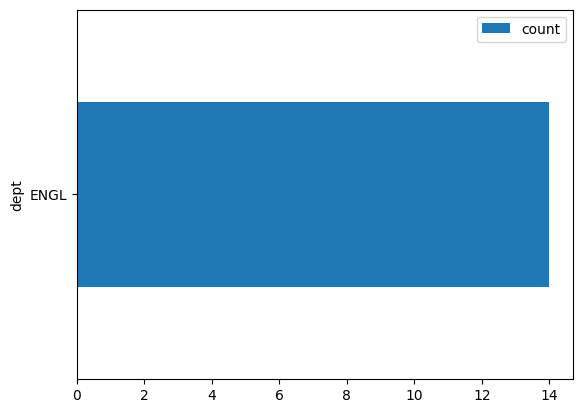

In [36]:
# You can call the function with specific courses
results = get_department_report('ENGL')


Departments with Records: 8
Total records: 100
CRWT Count: 16 Presence:16.0%
HIST Count: 16 Presence:16.0%
ENGL Count: 14 Presence:14.0%
ARST Count: 12 Presence:12.0%
LIBR Count: 12 Presence:12.0%
MUSI Count: 11 Presence:11.0%
MATH Count: 10 Presence:10.0%
SPAN Count: 9 Presence:9.0%


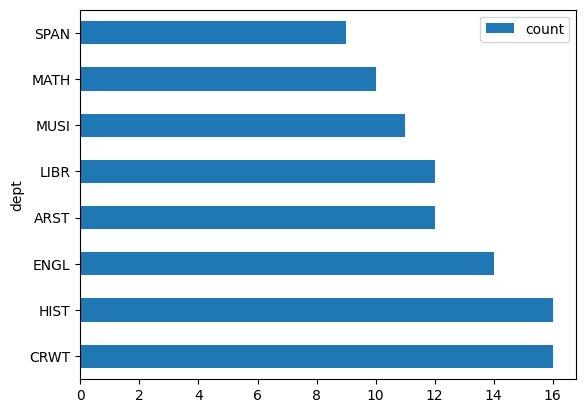

In [37]:
# Calling the function without a course/department id will list all of the courses/departments in LOCR
results = get_department_report()

In [38]:
def get_publisher_report(publisher='*',bShow=True):
  catalog = Catalog(df)
  if publisher == '*':
    catalog.sort('Publisher')
    results = catalog.get()
  else:
    results = catalog.search('Publisher',publisher)
  reports = count_by_column(results,'Publisher')
  if bShow == True:
    for rep in reports:
      print(f'{rep["Publisher"]} Count: {rep["count"]}')
  return reports

#### Generate Publisher Report
Search for a particular publisher, part of a publisher's name, or leave blank to list all publishers

In [39]:
results = get_publisher_report()

UBC Press Count: 15
Brick Books Count: 15
UC Berkeley Press Count: 14
Heyday Books Count: 13
Taylor & Francis Count: 11
MIT Press Count: 11
Yale University Press Count: 10
UCLA Press Count: 7
Doubleday Books Count: 4
